<a href="https://colab.research.google.com/github/adalbertii/modele-NLP/blob/main/BERT_Fine_Tuning_Sentence_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning przy wykorzystaniu PyTorch

BERT (Bidirectional Encoder Representations from Transformers), opublikowany w

Wykorzystamy BERT do szkolenia klasyfikatora tekstu. W szczególności weźmiemy wstępnie wytrenowany model BERT, dodamy na końcu nieprzetrenowaną warstwę neuronów i wytrenujemy nowy model na potrzeby  zadania klasyfikacji.

Wykorzystanie Colab GPU w procesie uczenia modelu


**Sprawdzenie dostępności procesaora GPU**

In [ ]:
import tensorflow as tf

# ustalenie nazwy dostępnego procesora
device_name = tf.test.gpu_device_name()

# Nazwa urządzenia powinna wyglądać następująco::
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


**Instalacja biblioteki  Hugging Face**



Zainstalujmy pakiet [transformers](https://github.com/huggingface/transformers) od Hugging Face, który udostępni nam interfejs pytorch do pracy z BERT-em. (Ta biblioteka zawiera interfejsy dla innych wstępnie wyszkolonych modeli języków, takich jak GPT i GPT-2 OpenAI.)

Biblioteka Hugging Face wydaje się być najszerzej akceptowanym i potężnym interfejsem pytorch do pracy z BERT. Oprócz obsługi różnych, wstępnie wytrenowanych modeli transformatorów, biblioteka zawiera także gotowe modyfikacje tych modeli, dostosowane do konkretnego zadania. Na przykład w tym samouczku użyjemy klasy „BertForSequenceClassification”.

Biblioteka zawiera również klasy specyficzne dla zadań do klasyfikacji tokenów, odpowiadania na pytania, przewidywania następnego zdania itp. Korzystanie z tych gotowych klas upraszcza proces modyfikowania BERT do własnych celów.

In [ ]:
!pip install transformers

**Załdowanie danych**  

Do klasyfikacji pojedynczych zdań użyjemy zbioru danych Corpus of Linguistic Acceptability (CoLA). Jest to zbiór zdań oznaczonych jako poprawne gramatycznie lub niepoprawne.

We'll use the `wget` package to download the dataset to the Colab instance's file system.

In [ ]:
!pip install wget # aby pobrać zbiór danych do systemu plików instancji Colab

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=83228e789ee8b013fd5e65123b35f297f99e3075b43eb4eef3d12e9018ea66ed
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget
import os

print('Downloading dataset...')

# Adres URL pliku zip .
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'


if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:

if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


**Analiza danych**

Z nazw plików wynika, że ​​dostępne są zarówno tokenizowane, jak i surowe wersje danych.

Nie możemy skorzystać z wersji wstępnie tokenizowanej, ponieważ aby zastosować wstępnie wytrenowany BERT, musimy skorzystać z tokenizera dostarczonego przez sam model.

Użyjemy bibliotek pandas  do przeanalizowania zbioru szkoleniowego  i przyjrzenia się kilku przykładowym tekstom

In [ ]:
import pandas as pd

# załadowanie danych do pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report kiczby zdań.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Wyświetlenie 10 losowych zdań
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
1570,r-67,1,NaN,I took it for granted that she was lying.
6446,d_98,1,NaN,You may pick any five flowers.
5867,c_13,1,NaN,No man has ever beaten the centaur.
4987,ks08,0,*,What did you meet someone who understands?
6313,c_13,1,NaN,Darin has eaten more squid than John has octopus.
4642,ks08,1,NaN,John has been driving the car.
700,bc01,0,*,John intimately spoke to Mary.
1589,r-67,1,NaN,"If so, I've lost $500."
5218,kl93,0,*,Each candidate who has any interest in semanti...
2872,l-93,1,NaN,The eggs mixed with the cream.


Dwie kolumny, na których nam naprawdę zależy, to zdanie i jego etykieta (0= gramatycznie nieakceptowalny, 1=akceptowalny).

Pięć zdań oznaczonych jako nieakceptowalne gramatycznie

**Podejmowane zadanie klasyfikacyjne jest znacznie  trudniejsze niż zadanie w rodzaju analizy nastrojów**!



In [ ]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
2693,Amanda carried at the package to New York.,0
7497,We put.,0
8300,Bill reading of Shakespeare satisfied me,0
3917,John met in the park a student.,0
5330,"Those people will, after the party, not come h...",0


In [ ]:
# ważna jest tutaj kowersja do typu np.array !!!!!
sentences = df.sentence.values
labels = df.label.values

**Tokenizacja i formatowanie danych wejściowych  zgodnie z wymaganiami modelu BERT**

**BERT Tokenizer**


Aby przekazać  tekst BERTowi, należy go podzielić na tokeny, a następnie te tokeny muszą zostać zmapowane do ich indeksów w słowniku tokenizera.

Tokenizację musi przeprowadzić tokenizer dołączony do BERT.

Będziemy tutaj używać wersji "uncased" .


In [ ]:
from transformers import BertTokenizer


print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Zastosujmy tokenizator do jednego, przykładowego zdania, aby zobaczyć wynik.


In [ ]:

print(' Original: ', sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Wydrukuj zdanie odwzorowane na identyfikatory tokenów (token ids).
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]



Skonwertujemy tekst za pomocą funkcji `tokenize.encode`, która zrealizuje obydwa kroki zamiast `tokenize` and `convert_tokens_to_ids` oddzielenie.
`

**Wymagane formatowanie modelu BERT**

Jesteśmy zobowiązani do:

    Dodania specjalnego tokena na początku i na końcu każdego zdania.
    Wypełnienie  i obcięcie  wszystkie zdanń do jednej stałej długości.
    Wyraźnie odróżnienie  tokenó rzeczywiste od tokenów dopełniających za pomocą "attention mask".


### Specjale Tokeny



**`[SEP]`**

Na końcu każdego zdania należy dodać specjalny token „[SEP]”.

Token ten jest artefaktem zadań składających się z dwóch zdań, podczas których BERT otrzymuje dwa osobne zdania i jest proszony o ustalenie czegoś (np. czy odpowiedź na pytanie w zdaniu A można znaleźć w zdaniu B?).


**`[CLS]`**

W przypadku zadań klasyfikacyjnych musimy dodać specjalny token „[CLS]” na początku każdego zdania.

Ten znak ma szczególne znaczenie. BERT składa się z 12 warstw transformatorowych. Każdy transformator pobiera listę osadzonych znaczników i wytwarza tę samą liczbę osadzonych na wyjściu (ale oczywiście ze zmienionymi wartościami funkcji!).

![Illustration of CLS token purpose](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)

Na wyjściu ostatniego (12.) transformatora klasyfikator wykorzystuje *tylko pierwsze osadzenie (odpowiadające tokenowi [CLS])*.


„Pierwszym żettokenem  każdej sekwencji jest zawsze specjalny token klasyfikacji („[CLS]”). Ostateczny stan ukryty
odpowiadający temu tokenowi jest używany jako zagregowana reprezentacja sekwencji do klasyfikacji
zadania.” (z [artykułu BERT](https://arxiv.org/pdf/1810.04805.pdf)




### Długość zdań & Attention Mask



Zdania w naszym zbiorze danych mają oczywiście różną długość, więc jak BERT sobie z tym radzi?

BERT ma dwa ograniczenia:

    Wszystkie zdania muszą być uzupełnione lub obcięte do jednej, stałej długości.
    Maksymalna długość zdania wynosi 512 tokenów.

Wypełnianie odbywa się za pomocą specjalnego tokena [PAD], który w słowniku BERT znajduje się pod indeksem 0. Poniższa ilustracja przedstawia uzupełnienie do „MAX_LEN” 8 tokenów

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

"Attention Mask" to po prostu tablica jedynek i zer wskazujących, które tokeny są dopełniane, a które nie . Ta maska ​​informuje mechanizm „samouwagi” w BERT, aby nie włączał tych tokenów PAD do swojej interpretacji zdania.

Maksymalna długość ma jednak wpływ na szybkość uczenia i oceny.
Na przykład w przypadku Tesli K80:



`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`







**Tokenizacja Dataset**

Biblioteka transformatorów udostępnia przydatną funkcję `encode`, która wykona za nas większość etapów analizowania i przygotowywania danych.

Zanim jednak będziemy gotowi do zakodowania naszego tekstu, musimy zdecydować o maksymalnej długości zdania do dopełnienia/obcięcia.

Poniższa komórka wykona jedno przejście tokenizacji zbioru danych w celu zmierzenia maksymalnej długości zdania.


In [ ]:
max_len = 0

# dla każdego zdania Dataset ...
for sent in sentences:

    # Tokenizacja i dodanie tokenów `[CLS]` i `[SEP]` .
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # aktualizacja maksymalnej fługości zdania
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


Na wypadek, gdyby istniały dłuższe zdania testowe, ustawię maksymalną długość na 64.


Teraz jesteśmy gotowi do przeprowadzenia prawdziwej tokenizacji.

Funkcja tokenizer.encode_plus łączy  wiele kroków:

    dzieli zdanie na tokeny.
    dodaje specjalne tokeny [CLS] i [SEP].
    przypisuje tokeny do ich identyfikatorów.
    dopełnia lub obcina wszystkie zdania do tej samej długości.
    tworzy maski uwagi, które wyraźnie odróżniają tokeny prawdziwe od tokenów [PAD].



In [ ]:
# Tokenizuje wszystkie zdania i przyporządkuj tokeny do identyfikatorów słów.(word IDs.)
input_ids = []
attention_masks = []

# Dla każdego zdania Dataset...
for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                           # zdanie do zakdodowania.
                        add_special_tokens = True,      # dodaje tokeny  '[CLS]' i '[SEP]'
                        max_length = 64,                # uzupełnienie i obcięcie zdania
                        pad_to_max_length = True,
                        return_attention_mask = True,   # utworzenie attntion masks.
                        return_tensors = 'pt',          # zwraca tensor pytorch .
                   )

    # dodanie zakdowanego zdania do  listy
    input_ids.append(encoded_dict['input_ids'])

    # i jego attention mask
    attention_masks.append(encoded_dict['attention_mask'])

# konwersja listy do tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# wydruk zdania  0, jako listy IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


**Podział Dataset na dane treningowe i walidacyjne**


In [ ]:
# 90% na szkolenie i 10% na walidację.

from torch.utils.data import TensorDataset, random_split

# połącznie danych wejściowych (w ramach obiektu TensorDataset).
dataset = TensorDataset(input_ids, attention_masks, labels)



# obliczenie liczby przykładów zdań przed ich umieszczeniem do każdego podzbioru
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# POdział Dataset przez losowy wybór przykładów
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


Utworzymy także iterator dla  zbioru danych, korzystając z klasy Torch DataLoader. Pomaga to zaoszczędzić pamięć podczas uczenia, ponieważ w przeciwieństwie do pętli for w przypadku iteratora cały zestaw danych nie musi być ładowany do pamięci.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# TDataLoader musi znać rozmiar naszej partii do szkolenia, więc go określamy
# Tutaj. W celu dostrojenia BERT do konkretnego zadania autorzy zalecają partię
# rozmiar 16 lub 32.
batch_size = 32

# Utwórz moduły DataLoaders dla naszych zestawów szkoleniowych i walidacyjnych.
# Próbki szkoleniowe pobierzemy w losowej kolejności.

train_dataloader = DataLoader(
            train_dataset,  # podzbiór treningowy
            sampler = RandomSampler(train_dataset), # losowy wybór batches
            batch_size = batch_size # rozmiar batch size.
        )

# Dla sprawdzenia poprawności kolejność nie ma znaczenia, więc po prostu przeczytamy je sekwencyjnie.


validation_dataloader = DataLoader(
            val_dataset, # Tpodzbór walidacyjny.
            sampler = SequentialSampler(val_dataset), # sekwencyjny odczyt batches.
            batch_size = batch_size # ewaluacja z rozmiarem batch size.
        )

Teraz, gdy nasze dane wejściowe są już prawidłowo sformatowane, czas dostroić model BERT

**Proces trenowania modelu klasyfikacyjnego**

**BertForSequenceClassification**

W przypadku tego zadania najpierw chcemy zmodyfikować wstępnie wytrenowany model BERT, aby uzyskać wyniki do klasyfikacji, a następnie chcemy kontynuować uczenie modelu na naszym zbiorze danych, aż cały model, od początku do końca, będzie dobrze dostosowany do nasze zadanie.

Na szczęście implementacja huggingface pytorch zawiera zestaw interfejsów zaprojektowanych do różnych zadań NLP. Chociaż wszystkie te interfejsy są zbudowane w oparciu o wyszkolony model BERT, każdy z nich ma różne górne warstwy i typy wyników zaprojektowane tak, aby dostosować się do ich konkretnego zadania NLP.

Oto aktualna lista klas przewidzianych do dostrojenia:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering



Będziemy używać [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). Jest to normalny model BERT z dodaną pojedynczą warstwą liniową na górze do klasyfikacji, której użyjemy jako klasyfikatora zdań. W miarę dostarczania danych wejściowych cały wstępnie wytrenowany model BERT i dodatkowa nieprzeszkolona warstwa klasyfikacyjna są szkolone pod kątem naszego konkretnego zadania.


Załadujmy BERT!
Dostępnych jest kilka różnych, wstępnie przeszkolonych modeli BERT. „bert-base-uncased” oznacza wersję zawierającą tylko małe litery („
i jest mniejszą wersją obu ("base" vs "large").


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# załadowanie wstępnie przeszkolonego modelu BertForSequenceClassification,  BERT za pomocą jednego
# z liniową warstwą klasyfikacji na górze.
# 110 milionów parametrów

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # wykorzystanie modelu 12 warstwowego .
    num_labels = 2, # liczby zmiennych objaśnianych 2 -- ponieważ mamy do czynienia z problemem klasyfikacji binarnej

    output_attentions = False, # czy model ma zwrócic waagi warstw attentions .
    output_hidden_states = False, # czy model ma zwrócić wszystkie hidden-states.
)

# dyrektywa wskazująca aby pytorch uruchomił ten model na procesorze GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Z ciekawości możemy tutaj przeglądać wszystkie parametry modelu po nazwie warstw.

W poniższej komórce wydrukowałem nazwy i wymiary tablic wag dla:

    Warstwa osadzająca.
    Pierwszy z dwunastu transformatorów.
    Warstwa wyjściowa.




In [ ]:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

**Optimizer & Learning Rate Scheduler**

Teraz, gdy mamy już załadowany model, musimy ustawić  hiperparametry szkoleniowe.
Autorzy modelu rekomendują:

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4

Wybrałem:
* Batch size: 32 (ustawione podczas inicjowania klasy  DataLoaders)
* Learning rate: 2e-5
* Epochs: 4

In [ ]:
# Note: AdamW jest klasą z biblioteki  huggingface library (zamiast z pytorch)
#
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - wartość domyslna 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - wartość domyślna to 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

#Liczba epok szkoleniowych. Autorzy BERT zalecają od 2 do 4.

epochs = 4

# całkowita liczba króków procesu uczenia = [number of batches] x [number of epochs].
# (to nie to samo co liczba wierszy w Dataset ).
total_steps = len(train_dataloader) * epochs

# utworzenie learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # wartość domyślna
                                            num_training_steps = total_steps)



---



**Główna pętla treningu modelu**


**Training:**
- rozpakowanie danych wejściowych  i etykiet
- załaduj danych do procesora graficznego w celu przyspieszenia
- usunięcie  gradientów  obliczonych  w poprzednim przejściu.
    - W pytorch gradienty gromadzą się domyślnie (przydatne w przypadku takich sieci jak RNN).
- Przejście do przodu (przesyłanie danych wejściowych przez sieć)
- Przejście wstecz (backpropagacja)
- zaktualizowanie  parametry za pomocą optymalizatora.step()
- śledzenie zmiennych w celu monitorowania postępu

**Evalution:**
- rozpakowanie danych wejściowych i etykiet
- załadowanie danych do procesora graficznego w celu przyspieszenia
- przejście do przodu (przesyłanie danych wejściowych przez sieć)
- oblicz straty na  danych walidacyjnych i śledzenie zmiennych w celu monitorowania postępu


**Definicja pomocniczej funkcji do obliczenia wskaznika accuracy.**

In [ ]:
import numpy as np


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

**Funkcja pomocnicza wyliczająca ulyw czasu obliczeń**


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''

    elapsed_rounded = int(round((elapsed)))

    # ustawienie foarmatu hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np


# ustawienie ziarna losowaości
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# będziemy zapamiętywać training  validation loss,
# validation accuracy, i timings.
training_stats = []

# pomiar całkowitego czasu procesu treningowego
total_t0 = time.time()

# dla każdej epoki ...
for epoch_i in range(0, epochs):

    # ========================================
    #               Trening
    # ========================================

    # Wykonanie jednego pełne przejście nad zestawem treningowym


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # pomiar jak długo trwała jedna epoka
    t0 = time.time()

    # zrestetowanie total loss dla tej epoki .
    total_train_loss = 0

    # przełączenie modelu w tryb treningu . Nie wykonuje samegotreningu jeszcze odel-train-do-in-pytorch)
    model.train()

    # dla każdego batch danych treningowych ...
    for step, batch in enumerate(train_dataloader):

        # Aktualizacja postępu co 40 partii.
        if step % 40 == 0 and not step == 0:
            # obliczenie upływu czasu w minutach .
            elapsed = format_time(time.time() - t0)

            # Raport postępu.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # rozpakowanie treningowego batch z obiektu dataloader.
        #
        # podczas rozpakowywnia kopiuję każdy tensor do GPU wykorzystując metodę 'to'
        #
        # `batch` trzy tensory pytorch :
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Usuwamy wcześniej obliczone gradienty przed wykonaniem przejście do tyłu.
        # PyTorch nie robi tego automatycznie, ponieważ gromadzenie gradientów jest „wygodne podczas treningu RNN”

        model.zero_grad()

        # Wykonanie przebiegu  w przód (ocena modelu na partii treningowej).

        # W zmiennej rezultat otrzymujemy 'Loss' i 'logits'
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        #  Abyśmy mogli na koniec zsumować i obliczyć średnią wartość 'loss' ' ze wszystkich partii

        total_train_loss += loss.item()

        # Wykonanie przejście do tyłu, aby obliczyć gradients.
        loss.backward()

        # przycięcie  gradients do 1.0.
        # zapobiega to tzw. "exploding gradients" .
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # aktualizacja parametró i wykonanie kroku wykorzystując wyliczony gradient.
        # Optymalizator narzuca reguły aktualizacji -- ja parametry są zmieniane w oparciu o gradients,  learning rate, itd..
        optimizer.step()

        # aktualizacja learning rate.
        scheduler.step()

    # obliczenie średniej wartości 'loss' dla wszystkich batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # pomiar jak długo trwała epoka .
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Walidacja
    # ========================================
    # po każdej treningowej epoce ,pomia performance na zbiorze walidacyjnym

    print("")
    print("Running Validation...")

    t0 = time.time()

    # ustawienie modelu w tryb ewaluacji --warstwy  dropout zachowują się odmiennie podczas ewaluacji .
    model.eval()

    # Tśledzenie zmiennych
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0


    for batch in validation_dataloader:

        # rozpakowanie danych walidacyjnych z dataloader.
        #
        # wraz z rozpakowywaniem  batch, rownież kopiujemy każdy tensor do GPU
        #
        # `batch` zawier tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # pytorch, nie będzie konstruował danych do wykresu
        with torch.no_grad():

            # przebieg Forward , obliczenie  logit predykcji.

            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)


        loss = result.loss
        logits = result.logits

        # obliczenie skumulowanje wartości loss
        total_eval_loss += loss.item()

        # pzreniesienie logits i labels do CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # obliczenie  accuracy dla batch testowych danych, i zapis
        # po każdym batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Raportaccuracydla procesu walidacji.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # obliczenie średniego loss dla wszystkich batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # pomiar jak długo trwał proces walidacji
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # zapis wsytskich statystyk dla tej epoki.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:14.
  Batch    80  of    241.    Elapsed: 0:00:27.
  Batch   120  of    241.    Elapsed: 0:00:41.
  Batch   160  of    241.    Elapsed: 0:00:54.
  Batch   200  of    241.    Elapsed: 0:01:07.
  Batch   240  of    241.    Elapsed: 0:01:20.

  Average training loss: 0.51
  Training epcoh took: 0:01:21

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.40
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:13.
  Batch    80  of    241.    Elapsed: 0:00:26.
  Batch   120  of    241.    Elapsed: 0:00:40.
  Batch   160  of    241.    Elapsed: 0:00:53.
  Batch   200  of    241.    Elapsed: 0:01:06.
  Batch   240  of    241.    Elapsed: 0:01:19.

  Average training loss: 0.31
  Training epcoh took: 0:01:19

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.41
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
 

In [ ]:
import datetime

x = datetime.datetime.now()
print(x)

2024-02-20 12:20:35.810190


**Podusmowanie procesu treningowego**

In [ ]:
import pandas as pd


#pd.set_option('precision', 2)

# utworzenie DataFrame ze statystyk treningowych .
df_stats = pd.DataFrame(data=training_stats)

# numer epoki jest identyfikatorem wiersza .
df_stats = df_stats.set_index('epoch')


df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.507637,0.398677,0.842207,0:01:21,0:00:03
2,0.307989,0.407326,0.848380,0:01:19,0:00:03
3,0.194342,0.501071,0.846451,0:01:20,0:00:03
4,0.133307,0.526205,0.856867,0:01:19,0:00:03


Podczas gdy straty szkoleniowe maleją z każdą epoką, straty walidacyjne rosną! Sugeruje to, że trenujemy nasz model zbyt długo i jest on nadmiernie dopasowany do danych uczących.


Starta  walidacyjna jest miarą bardziej precyzyjną niż accuracy, ponieważ przy dokładności nie interesuje nas dokładna wartość wyjściowa, ale tylko to, po której stronie progu ona się plasuje

Jeśli przewidujemy poprawną odpowiedź, ale z mniejszą pewnością, wówczas strata  walidacji to wyłapie, podczas gdy dokładność nie.



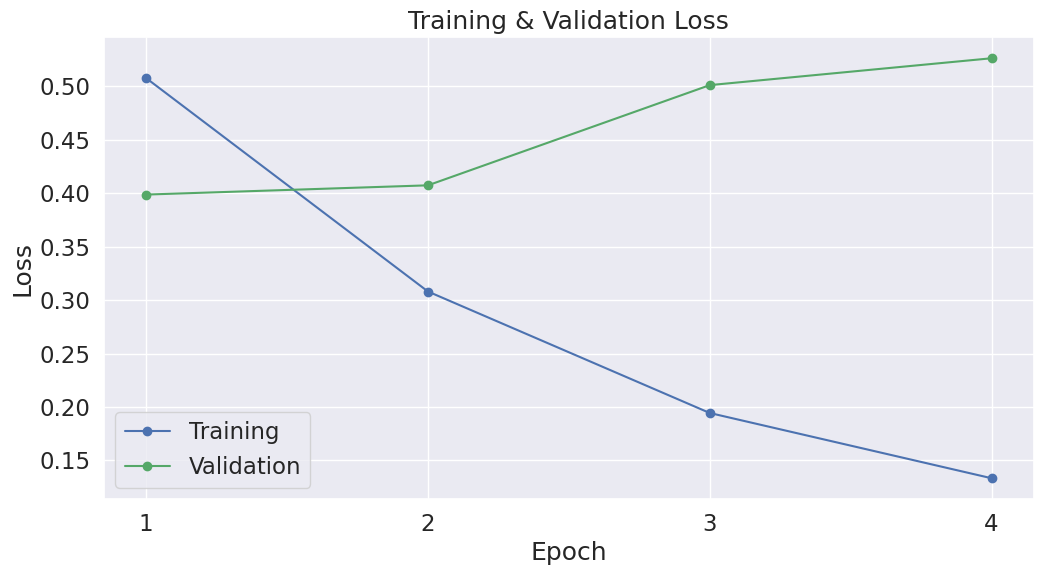

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# styl wykresu z seaborn.
sns.set(style='darkgrid')

# powększenie rozmiaru wykresu i trzcionki
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# wykres krzywej
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")


plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()



---


**Weryfikacja modelu przy użyciu danych testowych**

Etap przygotowania daych testowych
Ocena modelu przy użyciu współczynnika korelacji Matthew, ponieważ jest to miernik używany przez szerszą społeczność NLP do oceny wyników w CoLA.

 W przypadku tej metryki +1 to najlepszy wynik, a -1 to najgorszy wynik.
 W ten sposób możemy sprawdzić, jak dobrze radzimy sobie z najnowocześniejszymi modelami w przypadku tego konkretnego zadania.



Przygotowanie danych testowych


Zostana zastosowane  te same kroki, które zrobiliśmy w przypadku danych szkoleniowych

In [ ]:
import pandas as pd

# załadowanie danych do pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Raport liczby zdań
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# stworzenie podzbioru zdań i etykiet
sentences = df.sentence.values
labels = df.label.values

# tokenizacja zdań  i zmapowanie tokens do word IDs.
input_ids = []
attention_masks = []

# dla każdego zdania ze zbioru testowego...
for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # dodanie zakodowanych zdań do list.
    input_ids.append(encoded_dict['input_ids'])

    # i attention mask
    attention_masks.append(encoded_dict['attention_mask'])

# konwersja listy do tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

#
batch_size = 32

# stworzenie DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


**Ewaluacja modelu na danych testowych **



Po przygotowaniu zestawu testowego możemy zastosować model do wygenerowania prognoz na zestawie testowym.


In [ ]:
# predykcja na danych testowych

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# ustawienie modelu w tryb ewaluacji
model.eval()

# śledzenie zmiennych
predictions , true_labels = [], []

# predykcja
for batch in prediction_dataloader:
  # dodanie batch do GPU
  batch = tuple(t.to(device) for t in batch)

  # rozpakowanie testowych danych wejsciowych z dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # model nie będzie obliczał ani zapiyswał wartości gradientów oszczedzajac pamięc (dla przysieszenie procesu predykcji)
  with torch.no_grad():
      # .
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # przeniesienie logits i labels do CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # zapisnaie predykcji i prawdziwych etykiet
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


Dokładność testu porównawczego CoLA mierzy się za pomocą:

 "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

Używamy tutaj MCC, ponieważ klasy są zbalansowane


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

#
print('Calculating Matthews Corr. Coef. for each batch...')

# dla każdego wejściowego batch...
for i in range(len(true_labels)):
  # Prognozy dla tej partii to 2-kolumnowy ndarray (jedna kolumna dla „0”
  # i jedna kolumna dla „1”).
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # obliczenie wspólczynnikw dla tego batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


Ostateczny wynik będzie oparty na całym zestawie testowym, ale przyjrzyjmy się wynikom poszczególnych batch, aby uzyskać pojęcie o zmienności metryki pomiędzy batchs.

Każda partia zawiera 32 zdania, z wyjątkiem ostatniej partii, która ma tylko (516% 32) = 4 zdania testowe



<ipython-input-33-446d18042618>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


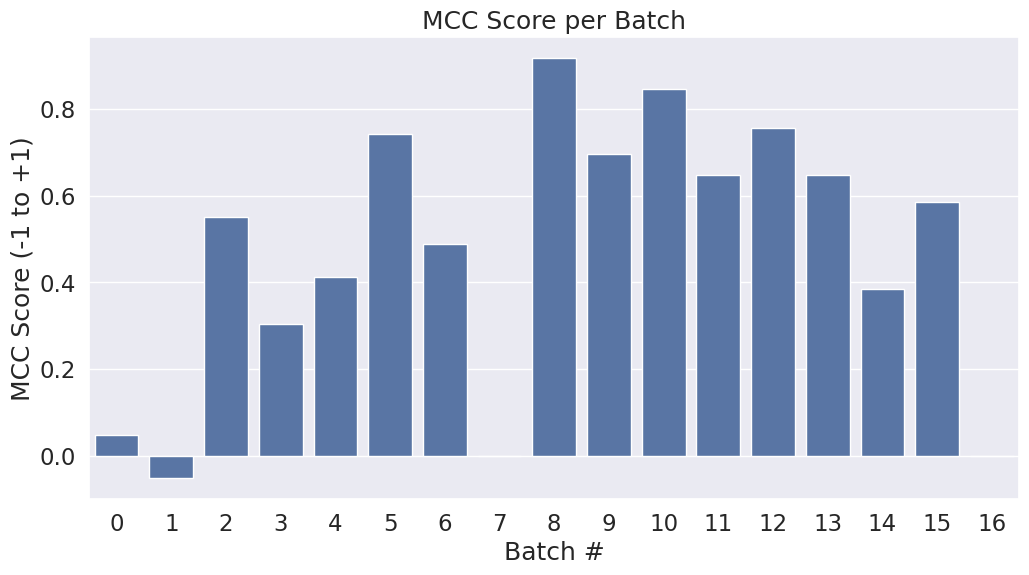

In [ ]:
# utworzenie wykresu słupkowego przedstawiającego  wynik MCC dla każdej partii próbek testowych
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Połączenie wyników dla wszystkich partii i obliczenie ostatecznego wyniku MCC.


In [ ]:
#
flat_predictions = np.concatenate(predictions, axis=0)

# dla każdego przykładu pobranie label (0 or 1) z najwyższym scoringiem .
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# połaczenie pozytywnych etykiet dla kazdej batch i zapis do jedenj listy
flat_true_labels = np.concatenate(true_labels, axis=0)

# obliczenie  MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.540


W około pół godziny i bez dostrajania hiperparametrów (dostosowywania szybkości uczenia się, epok, wielkości partii, właściwości ADAM-a itp.) jesteśmy w stanie uzyskać dobry wynik.

    Uwaga: aby zmaksymalizować wynik, powinniśmy usunąć „zestaw walidacyjny” (który pomógł nam określić, dla ilu epok należy trenować) i trenować na całym zestawie treningowym.

Biblioteka dokumentuje tutaj oczekiwaną dokładność tego testu porównawczego jako 49,23.

Należy pamiętać, że (ze względu na mały rozmiar zbioru danych?) dokładność może się znacznie różnić w zależności od przebiegu.




---


**Zapis modelu i jego załaadowanie**



In [ ]:
import os

# jeśli użyjemy domyślnych nazw modelu, możemy go ponownie załadować za pomocąmetody from_pretrained()

output_dir = './model_save/'

# utworzenie wynikowego katalogu (jełśi jest taka potrzeba)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# zapis modelu, konfiguracji i tokenizer wykorzystując metodę  `save_pretrained()`.
# Może on być załadowany później za pomocą metody   `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  #
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

#

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

Z ciekawości sprawdźmy rozmiary plików.

In [ ]:
!ls -l --block-size=K ./model_save/

total 427936K
-rw-r--r-- 1 root root      1K Feb 20 12:22 config.json
-rw-r--r-- 1 root root 427694K Feb 20 12:22 model.safetensors
-rw-r--r-- 1 root root      1K Feb 20 12:22 special_tokens_map.json
-rw-r--r-- 1 root root      2K Feb 20 12:22 tokenizer_config.json
-rw-r--r-- 1 root root    227K Feb 20 12:22 vocab.txt


Największym plikiem są wagi modelu, wynoszące około 418 megabajtów.

In [ ]:
!ls -l --block-size=M ./model_save/model.safetensors

-rw-r--r-- 1 root root 418M Feb 20 12:22 ./model_save/model.safetensors


To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# skopowanie pliku do Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Poniższe funkcje załadują model z powrotem z dysku

In [ ]:
#
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# kopiownie modelu do GPU.
model.to(device)